In [1]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
import sys
sys.path.append('../zdrojaky')
from tsplot import tsplot

# Sezónní model

Připomeňme, že jednoduchý sezónní model předpokládá komponenty $Y_t$ opakující se s periodou $s$ a které se mezi dvěma "sezónami" vysčítají do nuly (proč?). To jest,

$$
Y_{t+s} = Y_t, \qquad \sum_{i=1}^s Y_{t+i} = 0 \qquad \text{pro všechna $t$}. 
$$

Přidáme-li aditivní šum $\varepsilon_t\sim\mathcal{N}(0, \sigma^2)$, dostaneme sezónní model

$$
Y_t = -Y_{t-s+1} - Y_{t-s+2} - \ldots - Y_{t-1} + \varepsilon_t, \qquad t=s,s+1,\ldots
$$

$$
\mathbf{X}_t =
\begin{bmatrix}
Y_t \\ Y_{t-1} \\ \vdots \\ Y_{t-s+1}
\end{bmatrix}
$$

a výsledný stavový model

$$
\begin{align}
Y_t &= [1, 0, \ldots, 0]\ \mathbf{X}_t \\
\mathbf{X}_t &= 
\begin{bmatrix}
-1 & -1 & -1 & -1 & \ldots & -1 \\
1 & 0 & 0 & 0 & \ldots & 0 \\
0 & 1 & 0 & 0 & \ldots & 0 \\
0 & 0 & 1 & 0 & \ldots & 0\\
\vdots & \vdots & \ddots & \ddots & \ddots &\vdots \\
0 & 0 & \ldots & 0 & 1 & 0
\end{bmatrix}
\mathbf{X}_{t-1}
+ \begin{bmatrix}
\varepsilon_t \\ 0 \\ 0 \\ 0 \\ \vdots \\ 0
\end{bmatrix}
\end{align}
$$

Neznámý je tedy nepozorovaný šum a odhadovaným parametrem bude jeho variance $\sigma^2$.

# Model ve `statsmodels`

`statsmodels` mají velmi flexibilní přístup k definici [téměř libovolných stavových modelů](http://www.statsmodels.org/stable/statespace.html#custom-state-space-models). Celý princip spočívá v dědění od třídy `MLEModel` a úpravě 

- konstruktoru - zde především zadefinujeme matice modelu, viz [zde](http://www.statsmodels.org/stable/statespace.html#)
- metody `update()` - zde se zadefinuje poloha parametrů,
- případné další drobnosti jako
    - `param_names` - nejčastěji jako property, nese jména parametrů,
    - `transform_params()` a `untransform.params()` - třídy pro transformaci proměnných např. na nezápornost,
    - `start_params` - často jako property, iniciální hodnoty parametrů.

In [6]:
class SeasonalityModel(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Model order
        k_states = 12
        k_posdef = 1

        # Initialize the statespace
        super(SeasonalityModel, self).__init__(
            endog, k_states=k_states, k_posdef=k_posdef,
            initialization='approximate_diffuse',
            loglikelihood_burn=k_states
        )

        # Initialize the matrices
        self.ssm['design'][0,0] = 1
        trn = np.c_[np.eye(k_states-1), np.zeros((k_states-1,1))]
        trn = np.r_[-1*np.ones((1,k_states)), trn]
        self.ssm['transition'] = trn
        self.ssm['selection', 0, 0] = 1
        

    @property
    def param_names(self):
        return ['sigma2.process']

    @property
    def start_params(self):
        return [np.std(self.endog)*3]

    def transform_params(self, unconstrained):
        return unconstrained**2

    def untransform_params(self, constrained):
        return constrained**0.5

    def update(self, params, *args, **kwargs):
        params = super(SeasonalityModel, self).update(params, *args, **kwargs)
        
        # Observation covariance
        self.ssm['state_cov',0,0] = params[0]

Natáhneme data ze souboru a zkusíme je modelovat.

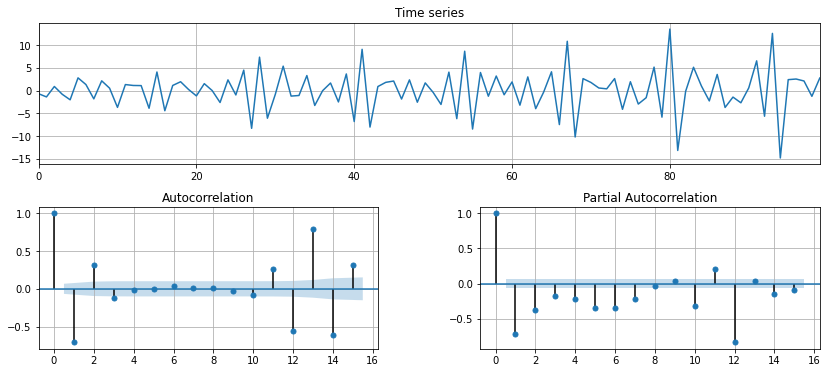

In [7]:
Y = np.load('../zdrojaky/seasonality_data.npz')['Y']
tsplot(Y)

In [8]:
model = SeasonalityModel(Y)
res = model.fit()
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  100
Model:               SeasonalityModel   Log Likelihood                -146.201
Date:                Tue, 10 Nov 2020   AIC                            294.402
Time:                        16:42:27   BIC                            296.879
Sample:                             0   HQIC                           295.400
                                - 100                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
sigma2.process     1.6240      0.250      6.486      0.000       1.133       2.115
Ljung-Box (L1) (Q):                   4.13   Jarque-Bera (JB):                 0.28
Prob(Q):                           

Metoda `fit()` třídy `MLEModel` vrací instanci `MLEResults`. Ta obsahuje poměrně [dost užitečných atributů a metod](http://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.mlemodel.MLEResults.html), mj. pro in-sample predikce (`get_prediction()`) a out-of-sample predikce (`get_forecast`). Vykreslíme si předpověď na příštích `nsteps` časových kroků.

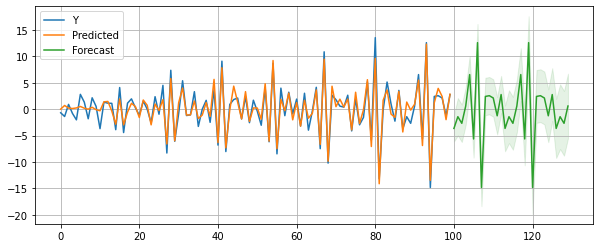

In [9]:
nsteps = 30
ndat = Y.size
predict = res.get_prediction()
forecast = res.get_forecast(nsteps)

plt.figure(figsize=(10,4))
plt.plot(Y, label='Y')
plt.plot(predict.predicted_mean, label='Predicted')
plt.plot(np.arange(ndat, ndat+nsteps), forecast.predicted_mean, label='Forecast')
forecast_ci = forecast.conf_int()
forecast_index = np.arange(ndat, ndat + nsteps)
plt.fill_between(forecast_index, forecast_ci[:, 0], forecast_ci[:, 1], color='green', alpha=0.1)
plt.legend()